In [1]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import deque

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

c:\Users\loren\anaconda3\envs\thesis_packs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [3]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_27216\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_27216\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_27216\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [4]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [5]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [6]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

data = data.dropna()

# BAYES

In [7]:
def plot_model_rmse_and_loss(train): 
    #evaluating train and validation accuracies and losses
    train_loss = train
    #val_loss = val
    #visualizing epochs vs. train and validation accuracies and losses
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')
    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

# DUMMY FOR WEEKEND

In [32]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(input_dim, 50),
            nn.ReLU(),
            BayesianLinear(50, 25),
            nn.ReLU(),
            BayesianLinear(25, output_dim)
        )

    def forward(self, x):
        x_ = self.layer(x)
        return x_

In [33]:
n_train = 35064
features = ['total_aggregated','business hour']
feature_array = data[features].values

# Fit Scaler only on Training target values
scaler = StandardScaler()
scaler.fit(feature_array[:n_train, 0].reshape(-1,1))

# Transfom on both Training and Test data
scaled_feature = scaler.transform(feature_array[:, 0].reshape(-1, 1))

scaled_array = np.copy(feature_array)
scaled_array[:, 0] = scaled_feature.flatten()

# Create a DataFrame from the observations
df = pd.DataFrame(scaled_array, columns=['total_aggregated', 'biz'])


# Create 24 lags and store them as new columns in the DataFrame
for i in range(1, 25):
    df[f'lag_{i}'] = df['total_aggregated'].shift(i)

# Interpolate missing values
df = df.bfill()

# Define the number of train and test observations
# Separate the lags (features) and the observation (target)
X = df.drop('total_aggregated', axis=1)
y = df['total_aggregated']

# Separate the features into training and test sets
X_train = X[:n_train]
X_test = X[n_train:]

y_train, y_test = y[:n_train], y[n_train:]

X_train3, X_test3, y_train3, y_test3 = torch.tensor(X_train.values).float(), torch.tensor(X_test.values).float(), torch.tensor(y_train.values).float(), torch.tensor(y_test.values).float()

In [34]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = int()):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    y_pred = scaler.inverse_transform(means.detach().numpy())

    stds = preds.std(axis=0)

    ci_upper = means + (std_multiplier * stds)
    upper_inv = scaler.inverse_transform(ci_upper.detach().numpy())

    ci_lower = means - (std_multiplier * stds)
    lower_inv = scaler.inverse_transform(ci_lower.detach().numpy())

    #y_true = scaler.inverse_transform(y.detach().numpy())

    #ic_acc = (ci_lower < y_vec) == (ci_upper > y_vec)
    #ic_acc = ic_acc.mean()
    return y_pred, upper_inv, lower_inv, stds # means.float(), ic_acc, (ci_upper >= y).float(), (ci_lower <= y).float(), stds.float()

In [35]:
regressor3 = BayesianRegressor(25,1)
optimizer = optim.Adam(regressor3.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()

ds_train = torch.utils.data.TensorDataset(X_train3, y_train3)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=168, shuffle=False)

ds_test = torch.utils.data.TensorDataset(X_test3, y_test3)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=168, shuffle=True)

Epoch 1 - Training Loss: 0.444931
Epoch 2 - Training Loss: 0.342759
Epoch 3 - Training Loss: 0.319727
Epoch 4 - Training Loss: 0.301205
Epoch 5 - Training Loss: 0.285451
Epoch 6 - Training Loss: 0.270081
Epoch 7 - Training Loss: 0.255332
Epoch 8 - Training Loss: 0.241613
Epoch 9 - Training Loss: 0.227944
Epoch 10 - Training Loss: 0.214360
Epoch 11 - Training Loss: 0.202244
Epoch 12 - Training Loss: 0.189393
Epoch 13 - Training Loss: 0.177377
Epoch 14 - Training Loss: 0.165852
Epoch 15 - Training Loss: 0.154733
Epoch 16 - Training Loss: 0.144191
Epoch 17 - Training Loss: 0.133678
Epoch 18 - Training Loss: 0.125038
Epoch 19 - Training Loss: 0.116005
Epoch 20 - Training Loss: 0.107828
Epoch 21 - Training Loss: 0.101588
Epoch 22 - Training Loss: 0.094435
Epoch 23 - Training Loss: 0.089152
Epoch 24 - Training Loss: 0.084957
Epoch 25 - Training Loss: 0.081548
Epoch 26 - Training Loss: 0.077201
Epoch 27 - Training Loss: 0.074309
Epoch 28 - Training Loss: 0.071921
Epoch 29 - Training Loss: 0.0

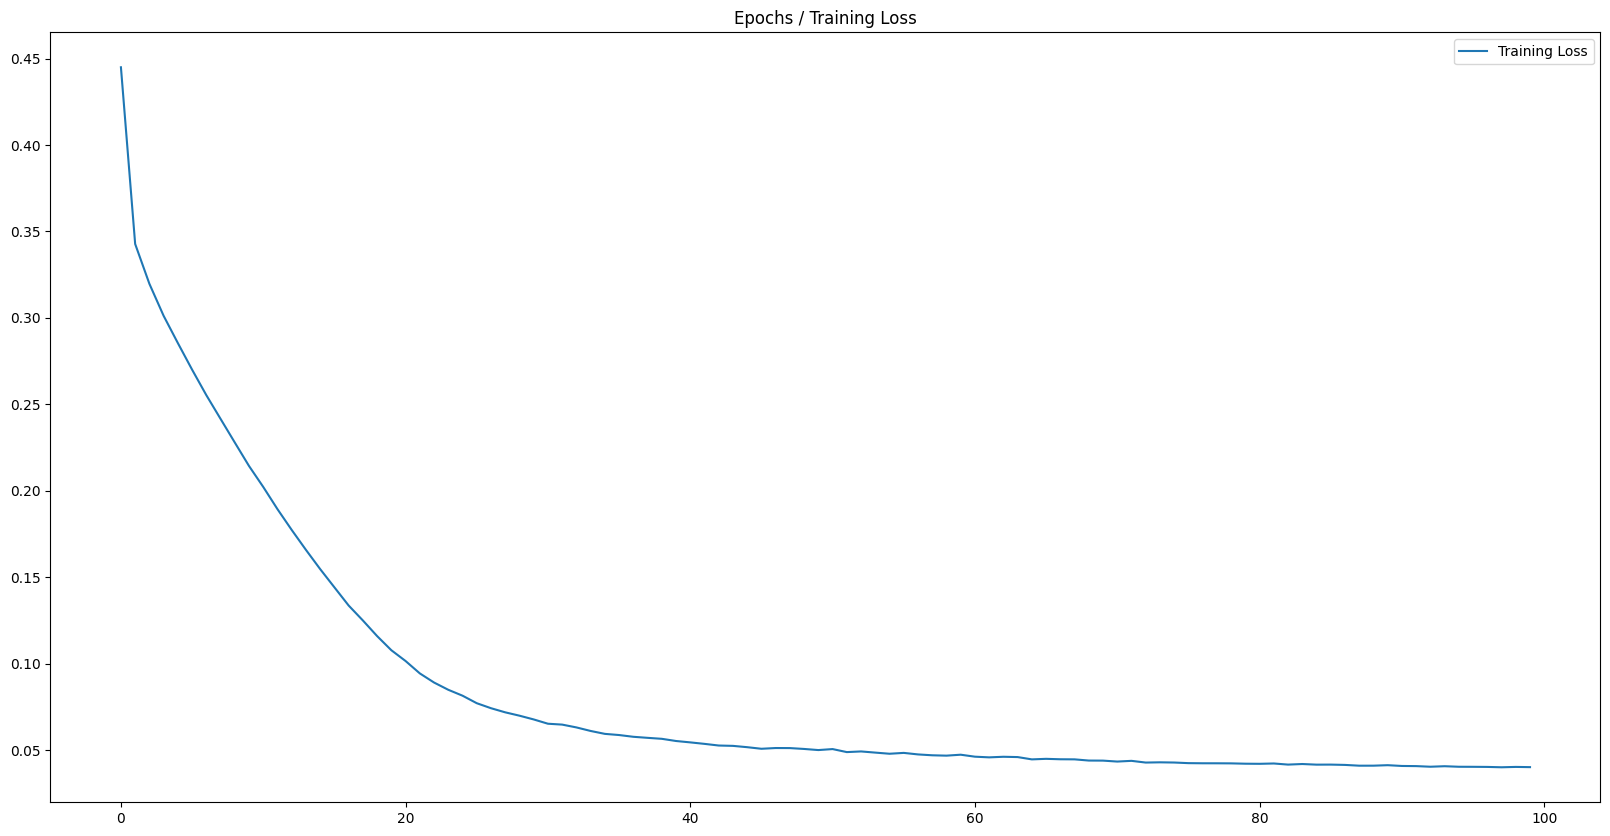

In [36]:
train_losses = []

iteration = 0
for epoch in range(100):
    regressor3.train()
    train_loss = 0.0
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor3.sample_elbo(inputs=datapoints,
                           labels=labels.unsqueeze(1),
                           criterion=criterion,
                           sample_nbr=4,
                           complexity_cost_weight=1./X_train.shape[0])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)
    
    print(f"Epoch {epoch+1} - Training Loss: {train_loss:.6f}")
plot_model_rmse_and_loss(train_losses)

In [37]:
#if iteration%100==0:
y_pred3, ci_upper3, ci_lower3, stds3 = evaluate_regression(regressor3,
                                                            X_test3,
                                                            y_test3,
                                                            samples=200,
                                                            std_multiplier=5)

print("Loss: {:.4f}".format(loss)) # , CI acc: {:.2f}: , CI under upper acc: {:.2f}, CI over lower acc: {:.2f} ci_upper, ci_lower

Loss: 0.0345


In [38]:
y_true = scaler.inverse_transform(np.array(y_test3.detach().numpy()).reshape(-1,1))

In [39]:
u_upper3 = ci_upper3 >= y_true
o_lower3 = ci_lower3 <= y_true
total3 = (u_upper3 == o_lower3)
#
print("{} our predictions are in our confidence interval".format(np.mean(total3)))

0.9327975376196991 our predictions are in our confidence interval


In [40]:
truth = []
for i in y_true:
    truth.append(float(i))

In [41]:
res = pd.DataFrame()
res['y_true'] = truth
res['y_pred'] = y_pred3
res['upper_ci_bound'] = ci_upper3
res['lower_ci_bound'] = ci_lower3

mse = sqrt(np.mean((res.y_pred - res.y_true)**2))
print('Mean Squared Error:', mse)

Mean Squared Error: 1065.9589876640287


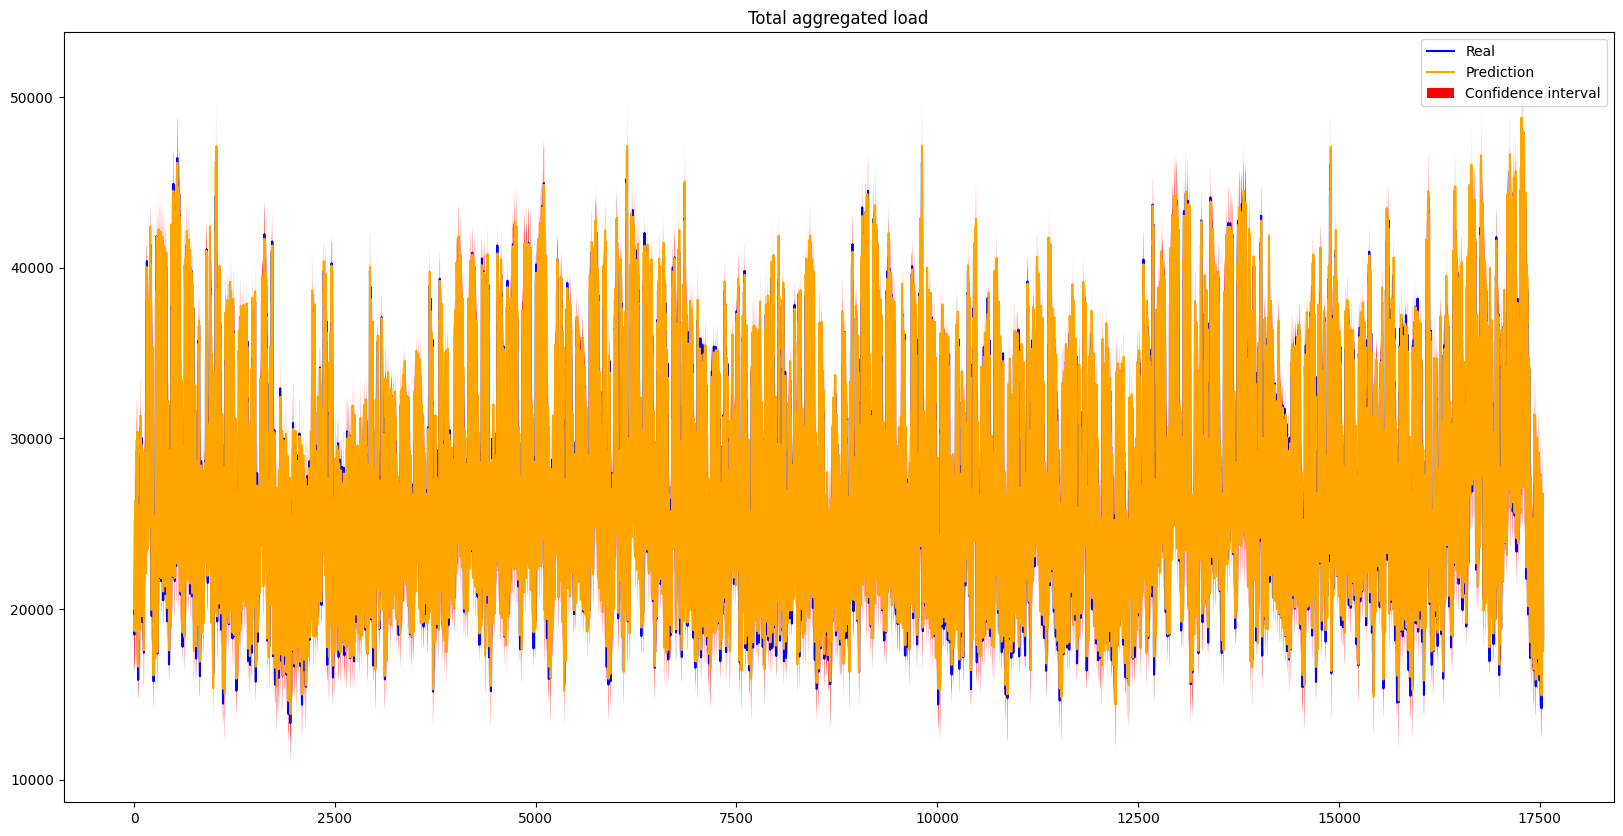

In [42]:
#plot_preds_vs_actual(res.y_true, res.y_pred)
plt.figure(figsize=(20,10))
plt.title("Total aggregated load", color="black")

plt.plot(res.index,
         res.y_true,
         color='Blue',
         label="Real")

plt.plot(res.index,
         res.y_pred,
         label="Prediction",
         color="orange")

plt.fill_between(x=res.index,
                 y1=res.upper_ci_bound,
                 y2=res.lower_ci_bound,
                 facecolor='red',
                 label="Confidence interval",
                 alpha=1)

plt.legend()